In [ ]:
import gdown
import zipfile
import os

# Google Drive file ID
file_id = '1enE72o1lXL3jd7rxONi2pCH5ROOiHC5M'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Path to save the downloaded file
download_path = 'Dataset_EE.zip'  # Name of the downloaded zip file

# Download the file using gdown
gdown.download(url, download_path, quiet=False)

# Define the extraction path
extraction_path = 'dataset/'

# Ensure the extraction directory exists
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

# Extract the file if it's a zip file
if download_path.endswith('.zip'):
    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall(path=extraction_path)

    print(f'Files extracted to {extraction_path}')
else:
    print(f"The downloaded file is not a zip file. Please check the file format.")

In [1]:
# import os
# from pdf2image import convert_from_path
# pdf_folder = "dataset/Dataset_EE"

# def convert_pdfs_to_images(folder):
#     pdf_files = [f for f in os.listdir(folder) if f.endswith('.pdf')]
#     all_images = {}

#     for doc_id, pdf_file in enumerate(pdf_files):
#         pdf_path = os.path.join(pdf_folder, pdf_file)
#         images = convert_from_path(pdf_path, dpi=100)
#         all_images[doc_id] = images

#     return all_images

# all_images = convert_pdfs_to_images("dataset/Dataset_EE")

import os
import sqlite3
from pdf2image import convert_from_path
from io import BytesIO

# === CONFIG ===
pdf_folder = "dataset/Dataset_EE_Completed"
db_file = "pdf_images_completed.db"

# === CREATE TABLE ===
def init_db(db_path):
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS images (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            doc_id INTEGER,
            page_num INTEGER,
            image BLOB
        )
    ''')
    conn.commit()
    conn.close()

# === CONVERT AND SAVE ===
def convert_and_save(folder, db_path):
    pdf_files = [f for f in os.listdir(folder) if f.endswith('.pdf')]
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(folder, pdf_file)
        images = convert_from_path(pdf_path, dpi=100)

        for page_num, image in enumerate(images, start=1):
            # Convert PIL image to bytes
            img_bytes = BytesIO()
            image.save(img_bytes, format='PNG')
            img_data = img_bytes.getvalue()

            # Insert into DB
            cursor.execute('''
                INSERT INTO images (doc_id, page_num, image)
                VALUES (?, ?, ?)
            ''', (doc_id, page_num, img_data))

    conn.commit()
    conn.close()
    print("✅ Images saved to database.")

# === RUN ===
init_db(db_file)
convert_and_save(pdf_folder, db_file)


✅ Images saved to database.


In [16]:
# # import matplotlib.pyplot as plt

# # fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# # for i, ax in enumerate(axes.flat):
# #     img = all_images[1][i]
# #     ax.imshow(img)
# #     ax.axis('off')

# # plt.tight_layout()
# # plt.show()

# import matplotlib.pyplot as plt
# from PIL import Image
# import os
# import sqlite3
# from pdf2image import convert_from_path
# from io import BytesIO

# # === READ AND DISPLAY IMAGES FROM DATABASE ===
# def load_images_from_db(doc_id, limit=8, db_path="pdf_images.db"):
#     conn = sqlite3.connect(db_path)
#     cursor = conn.cursor()
#     cursor.execute('''
#         SELECT page_num, image FROM images
#         WHERE doc_id = ?
#         ORDER BY page_num ASC
#         LIMIT ?
#     ''', (doc_id, limit))
#     rows = cursor.fetchall()
#     conn.close()

#     images = []
#     for page_num, img_blob in rows:
#         img = Image.open(BytesIO(img_blob))
#         images.append((page_num, img))
#     return images

# # === DISPLAY THE IMAGES USING MATPLOTLIB ===
# doc_id = 1
# result_images = load_images_from_db(doc_id)

# fig, axes = plt.subplots(2, 4, figsize=(15, 10))

# for i, ax in enumerate(axes.flat):
#     if i < len(result_images):
#         page_num, img = result_images[i]
#         ax.imshow(img)
#         ax.set_title(f"Page {page_num}")
#         ax.axis('off')
#     else:
#         ax.axis('off')

# plt.tight_layout()
# plt.show()

import sqlite3
from io import BytesIO
from PIL import Image

# Load images from the database into all_images
def load_images_from_db(db_path="pdf_images.db"):
    all_images = {}
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Fetch all doc_ids from the database
    cursor.execute('''SELECT DISTINCT doc_id FROM images''')
    doc_ids = cursor.fetchall()

    for doc_id_tuple in doc_ids:
        doc_id = doc_id_tuple[0]
        cursor.execute('''SELECT page_num, image FROM images WHERE doc_id = ? ORDER BY page_num ASC''', (doc_id,))
        rows = cursor.fetchall()
        
        # Store images in a dictionary
        images = []
        for page_num, img_blob in rows:
            img = Image.open(BytesIO(img_blob))
            images.append(img)
        all_images[doc_id] = images

    conn.close()
    return all_images

# Load the images from the database
all_images = load_images_from_db("pdf_images.db")

In [1]:
from byaldi import RAGMultiModalModel

colpali_model = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.3")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
from byaldi import RAGMultiModalModel

# Load existing indexed model (from disk)
colpali_model = RAGMultiModalModel.from_index("image_index")

In [2]:
colpali_model.index(
    input_path="dataset/Dataset_EE_Completed",
    index_name="image_index_full",
    store_collection_with_index=True,
    overwrite=True
)

Indexing file: dataset/Dataset_EE_Completed/kirtley_permanent_magnets.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page 25 of docume

{0: 'dataset/Dataset_EE_Completed/kirtley_permanent_magnets.pdf',
 1: 'dataset/Dataset_EE_Completed/kirtley_transformer.pdf',
 2: 'dataset/Dataset_EE_Completed/neamen_metal_semiconductor_heterojunctions.pdf',
 3: 'dataset/Dataset_EE_Completed/hayt_time_varying_fields_and_maxwell_eq.pdf',
 4: 'dataset/Dataset_EE_Completed/hayt_plane_wave_reflection_and_dispersion.pdf',
 5: 'dataset/Dataset_EE_Completed/nise_design_via_state_space.pdf',
 6: 'dataset/Dataset_EE_Completed/hayt_guided_waves.pdf',
 7: 'dataset/Dataset_EE_Completed/sedra_bjt.pdf',
 8: 'dataset/Dataset_EE_Completed/kirtley_transmission_lines.pdf',
 9: 'dataset/Dataset_EE_Completed/kreyszig_pdes.pdf',
 10: 'dataset/Dataset_EE_Completed/kreyszig_complex_integration.pdf',
 11: 'dataset/Dataset_EE_Completed/haykin_continuous_wave_modulation.pdf',
 12: 'dataset/Dataset_EE_Completed/alan_laplace_transform.pdf',
 13: 'dataset/Dataset_EE_Completed/sadiku_sinusoidal_steady_state_analysis.pdf',
 14: 'dataset/Dataset_EE_Completed/sedra_t

In [13]:
# import matplotlib.pyplot as plt

# def display_images_for_query(query, colpali_model, all_images):
#     # Step 1: Search for the query using colpali_model
#     results = colpali_model.search(query, k=2)

#     # Step 2: Get the associated images based on search results
#     def get_result_images(results, all_images):
#         grouped_images = []
#         for result in results:
#             doc_id = result['doc_id']
#             page_num = result['page_num']

#             # Ensure valid page number within bounds
#             if doc_id in all_images and page_num - 1 < len(all_images[doc_id]):
#                 grouped_images.append(all_images[doc_id][page_num - 1])
#             else:
#                 print(f"Warning: Invalid page number {page_num} for doc_id {doc_id}")
        
#         return grouped_images

#     # Get images for the query
#     result_images = get_result_images(results, all_images)

#     # Step 3: Display the images
#     num_images = len(result_images)  # Number of images found
#     cols = 2  # Set columns to 2 as required

#     # Ensure at least one row if there are images
#     rows = (num_images // cols) + (1 if num_images % cols != 0 else 0)  # Calculate rows needed
#     if num_images > 0:
#         fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
#         axes = axes.flatten()  # Flatten the axes array

#         # Loop through and display the images
#         for i, ax in enumerate(axes):
#             if i < num_images:
#                 img = result_images[i]
#                 ax.imshow(img)
#                 ax.set_title(f"Image {i+1}")
#             ax.axis('off')  # Turn off axes

#         plt.tight_layout()
#         plt.show()
#     else:
#         print("No images found for the query.")

In [3]:
# from byaldi import RAGMultiModalModel

# # Load existing indexed model (from disk)
# colpali_model = RAGMultiModalModel.from_index("image_index")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


You are using in-memory collection. This means every image is stored in memory.
You might want to rethink this if you have a large collection!
Loaded 1127 images from 3 JSON files.


In [14]:
# # Example usage
# query = "opamp formula every types in table"
# display_images_for_query(query, colpali_model, result_images)

No images found for the query.


In [ ]:
# # Example usage
# query = "fourier series formula"
# display_images_for_query(query, colpali_model, all_images)

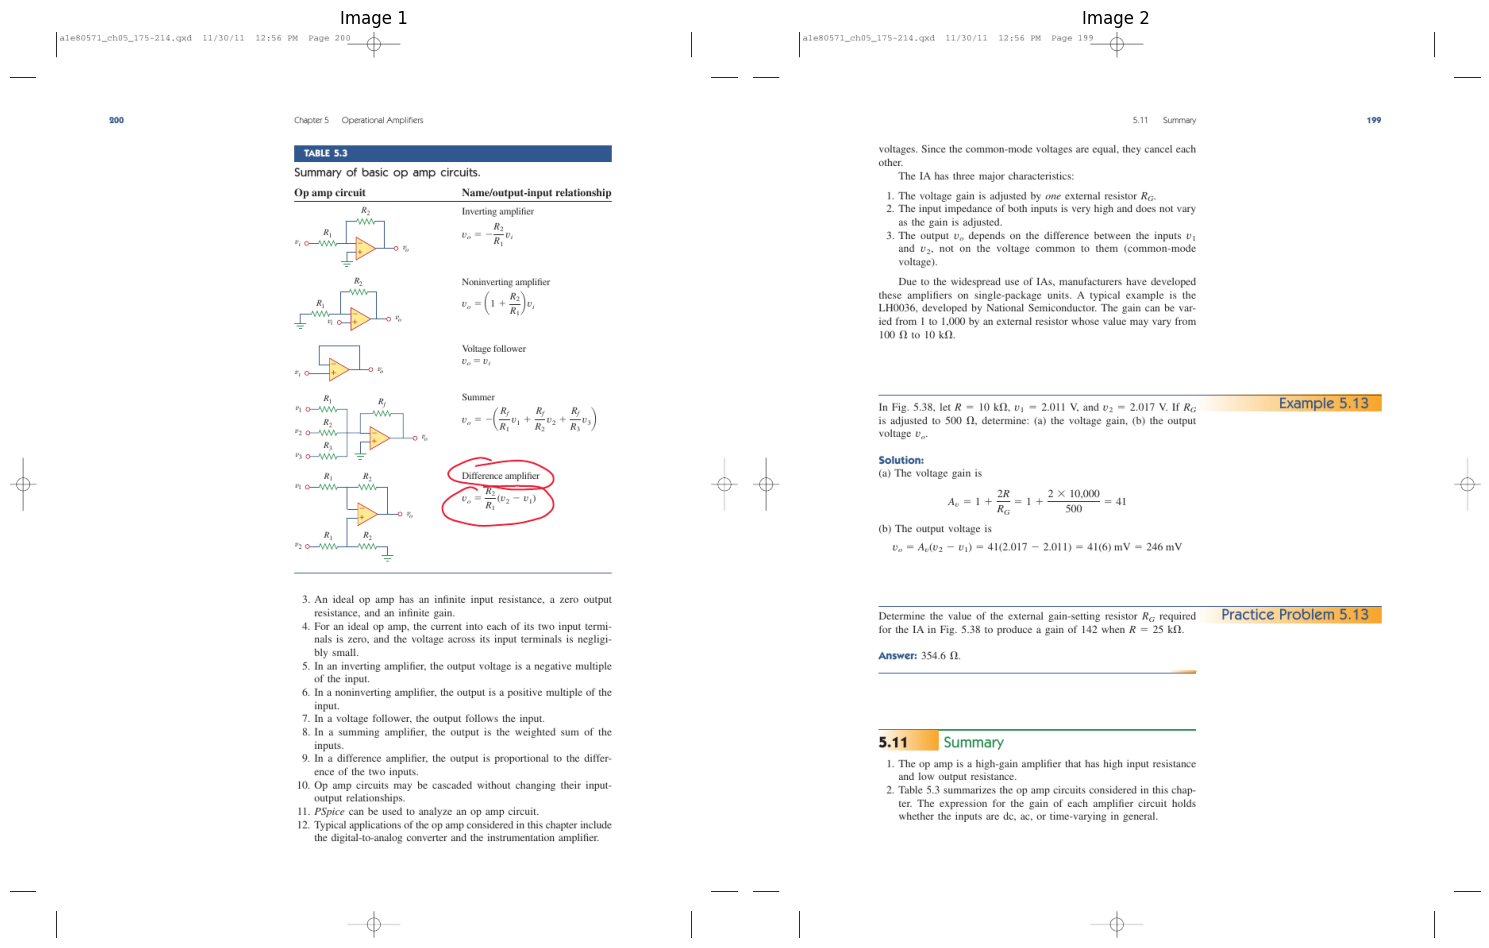

In [17]:
import matplotlib.pyplot as plt

def display_images_for_query(query, colpali_model, all_images):
    # Step 1: Search for the query using colpali_model
    results = colpali_model.search(query, k=2)

    # Step 2: Get the associated images based on search results
    def get_result_images(results, all_images):
        grouped_images = []
        for result in results:
            doc_id = result['doc_id']
            page_num = result['page_num']

            # Ensure valid page number within bounds
            if doc_id in all_images and page_num - 1 < len(all_images[doc_id]):
                grouped_images.append(all_images[doc_id][page_num - 1])
            else:
                print(f"Warning: Invalid page number {page_num} for doc_id {doc_id}")
        
        return grouped_images

    # Get images for the query
    result_images = get_result_images(results, all_images)

    # Step 3: Display the images
    num_images = len(result_images)  # Number of images found
    cols = 2  # Set columns to 2 as required

    # Ensure at least one row if there are images
    rows = (num_images // cols) + (1 if num_images % cols != 0 else 0)  # Calculate rows needed
    if num_images > 0:
        fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
        axes = axes.flatten()  # Flatten the axes array

        # Loop through and display the images
        for i, ax in enumerate(axes):
            if i < num_images:  # Only display images if there are results
                img = result_images[i]
                ax.imshow(img)
                ax.set_title(f"Image {i+1}")
            ax.axis('off')  # Turn off axes

        plt.tight_layout()
        plt.show()
    else:
        print("No images found for the query.")

# Example usage
query = "opamp formula every types in table"
display_images_for_query(query, colpali_model, all_images)


NameError: name 'gdown' is not defined